## **Import the TensorFlow library**

This code contains a small script that is used for generating a folder full of images. The idea is to show these images to the OpenMV camera when the training with the OL methos is required. Since the idea is to apply a supervised training is required to have a ground truth forthe computation of the error that the model is doing. This script fills a directory with images of digits and creates a txt file in which all the labels are saved. 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import random 
import csv 
import sys
import os
import re
from random import seed

import time

import glob
from keras import applications
#from keras.applications import vgg19
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

from numpy.ma.core import size

ROOT_PATH = os.path.abspath('')
sys.path.insert(0, ROOT_PATH + '/lib')
from lib.simulation_lib import *

# LOAD DATASETS

In [3]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


In [4]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)

#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


j,k = 0,0
for i in range(0,test_samples):
    if(label_test[i]>5):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1  
    else:
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1

In [5]:
# Does something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


In [6]:
# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

# LOAD TRAINED MODEL AND FEATURES

In [7]:
# MODEL_PATH = ROOT_PATH + "/Saved_models/Backup_models/Last_trained_model/"


In [8]:
###features = np.loadtxt(MODEL_PATH + 'Original_model/ll_features_10.txt')

In [9]:
#labels_features = np.loadtxt(MODEL_PATH + 'Original_model/ll_labels_features_10.txt')
#labels_features = labels_features.astype(int)

In [10]:
#model = keras.models.load_model(MODEL_PATH + 'Original_model/mnist_cnn.h5')

In [11]:
#model_frozen = keras.models.load_model(MODEL_PATH + 'Frozen_model/omv_mnist_cnn.h5')

In [12]:
#model.summary()

# K-MEAN FUNCTIONS

In [14]:
def create_k_mean(data, number_of_clusters):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters

    k = KMeans(n_clusters=number_of_clusters, n_init=100)
    # k = KMeans(n_clusters=number_of_clusters, n_init=20, max_iter=500)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing
    end = time.time()

    # And see how long that took
    # print("Training took {} seconds".format(end - start))

    return k

In [15]:
def cluster_label_count(clusters, labels):
    count = {}

    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))

    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}

        for label in unique_labels:
            count[cluster][label] = 0

    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] += 1

    cluster_df = pd.DataFrame(count)

    return cluster_df, count

In [16]:
def k_mean_clustering(features_x_test, features_init, y_test, labels_features_init, n_cluster, batch_size):

  # creo due vettori vuoti uno per le label lungo (n_features) l'altro per le features lungo (n_features,512)
  features = np.zeros((int(n_cluster*len(labels_features_init)/10),512))
  labels_features = np.zeros(int(n_cluster*len(labels_features_init)/10))
  k = 0 #inizializzo un counter

  #passo il vettore salvato nel file e mi tiro fuori solo i numeri che mi interessano. Se ho 6 cluster, mi interessano solo gli 0, 1, 2, 3, 4 e 5.
  for i in range(0,len(features_init)-1):
      if labels_features_init[i] < n_cluster:
        features[k,:] = features_init[i,:]
        labels_features[k] = labels_features_init[i]
        k += 1
  
  labels_features = labels_features.astype(int)

  # aggiungo la feature che di cui ci interessa trovare la pseudo label
  features = np.concatenate((features, features_x_test))
  labels_features = np.append(labels_features, y_test)
  n_count = np.zeros((batch_size, n_cluster)).astype(int) #inizializzo un vettore che ci permette di contare per ogni cluster quali numeri sono stati inseriti

  # viene fatto il clustering
  k_mean = create_k_mean(features ,n_cluster)

  # qui viene riempito il vettore conteggio. Se l'immagine che ci interessa classificare è stata inserita nel cluster 0, il ciclo guarderà 
  # tutte le labels delle immagini che sono state messe in quel cluster e la label che compare più volte sarà la pseudo_label della nostra immagine
  for j in range(1, batch_size+1):
    for i in range(0,len(k_mean.labels_) - batch_size):
        if k_mean.labels_[i] == k_mean.labels_[-j]:
         if labels_features[i] == 0:
           n_count[-j,0] +=1
         if labels_features[i] == 1:
           n_count[-j,1] +=1
         if labels_features[i] == 2:
           n_count[-j,2] +=1
         if labels_features[i] == 3:
           n_count[-j,3] +=1
         if labels_features[i] == 4:
           n_count[-j,4] +=1
         if labels_features[i] == 5:
           n_count[-j,5] +=1
         if labels_features[i] == 6:
           n_count[-j,6] +=1
         if labels_features[i] == 7:
           n_count[-j,7] +=1
         if labels_features[i] == 8:
           n_count[-j,8] +=1
         if labels_features[i] == 9:
           n_count[-j,9] +=1
  
  pseudo_label = np.zeros(batch_size)
  err = 0      

  # We extract the label for the new element
  for i in range(0,batch_size):
    pseudo_label[i]  =   np.argmax(n_count[i,:])  
    if pseudo_label[i]!= labels_features[i+int(n_cluster*len(labels_features_init)/10)]:
      err += 1
  # CHECK

  #rint("The vector count is: ")
  #print(n_count)
  #print("\n")
    
  #print("The pseudo label is are: ")
  #print(pseudo_label)
  #print("\n")
  #print("The true label is are: ")
  #print(y_test)
  #print("\n")

  #print("The image has been clustered in the group:  ")
  #print(k_mean.labels_[-1])
  #print("\n")
  
  # Delete the last feature and the last label
  features = np.delete(features, len(features)-1, 0)

  # Print control table
  #print("KMeans applied on numbers: \n")
  #clusters, count = cluster_label_count(k_mean.labels_, labels_features.astype(int))
  #print(clusters)
  #print("\n")

  #elimino label che abbiamo concatenato
  labels_features = np.delete(labels_features, len(labels_features)-1, 0)

  return pseudo_label, err

# FUNCTIONS

In [17]:
def softmax(array):
    
    if(len(array.shape)==2):
        array = array[0]
        
    size    = len(array)
    ret_ary = np.zeros([len(array)])
    m       = array[0]
    sum_val = 0

    for i in range(0, size):
        if(m<array[i]):
            m = array[i]

    for i in range(0, size):
        sum_val += np.exp(array[i] - m)

    constant = m + np.log(sum_val)
    for i in range(0, size):
        ret_ary[i] = np.exp(array[i] - constant)
        
    return ret_ary

In [18]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
        self.ML_frozen.compile()
        
        self.W = np.array(model.layers[-1].get_weights()[0])    # extract the weights from the last layer
        self.b = np.array(model.layers[-1].get_weights()[1])    # extract the biases from the last layer
               
        self.W_2 = np.zeros(self.W.shape)
        self.b_2 = np.zeros(self.b.shape)
        
        self.label     = [0,1,2,3,4,5]              
        self.std_label = [0,1,2,3,4,5,6,7,8,9]
        
        self.l_rate = 0                                         # learning rate that changes depending on the algorithm        

        self.batch_size = 0
        
        # Related to the results fo the model
        self.conf_matr = np.zeros((10,10))    # container for the confusion matrix       
        self.macro_avrg_precision = 0       
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''       # title that will be displayed on plots
        self.filename = ''    # name of the files to be saved (plots, charts, conf matrix)
        
        
    # Function that is used for the prediction of the model saved in this class
    def predict(self, x):
        mat_prod = np.array(np.matmul(x, self.W) + self.b)
        return softmax(mat_prod) # othwerwise do it with keras|also remove np.array()| tf.nn.softmax(mat_prod) 

In [19]:
def digitToSoftmax(current_label, known_labels):
    ret_ary = np.zeros(len(known_labels))

    known_labels_2 = [0,1,2,3,4,5]
                       
    for i in range(0, len(known_labels)):
        if(current_label == known_labels_2[i]):
            ret_ary[i] = 1

    return ret_ary  


In [20]:
def NumberToSoftmax(current_label, known_labels):
    ret_ary = np.zeros(len(known_labels))
                       
    for i in range(0, len(known_labels)):
        if(current_label == known_labels[i]):
            ret_ary[i] = 1

    return ret_ary

In [21]:
def CheckLabelKnown(model, current_label):
    
    found = 0
    
    for i in range(0, len(model.label)):
        if(current_label == model.label[i]):
            found = 1
        
        
    # If the label is not known
    if(found==0):
        print(f'\n\n    New digit detected -> digit \033[1m{current_label}\033[0m \n')

        model.label.append(current_label)   # Add new digit to label
                
        # Increase weights and biases dimensions
        model.W = np.hstack((model.W, np.zeros([model.W.shape[0],1])))
        model.b = np.hstack((model.b, np.zeros([1])))
        
        model.W_2 = np.hstack((model.W_2, np.zeros([model.W.shape[0],1])))
        model.b_2 = np.hstack((model.b_2, np.zeros([1])))

In [22]:
def trainOneEpoch_OL(model, x_train, x_test, y_train, y_test, features, labels_features, batch_size):
       
    cntr = 1
    learn_rate = model.l_rate
    
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    tot_samples = train_samples+test_samples
    
    x_tot = np.concatenate((x_train, x_test))
    y_tot = np.concatenate((y_train, y_test))
    
    n_cluster = 10
    err_tot = 0
    cntr_clus = 0
    reminder = tot_samples%batch_size
    max_iter = int(tot_samples//batch_size)

    features_images = np.zeros(tot_samples)
        
    # FEATURE EXTRACTION

    print('**********************************\n Performing features extraction \n')

    for i in range(0, tot_samples):
        y_ML   = model.ML_frozen.predict(x_tot[i].reshape((1,28,28,1)), verbose=False)

        if i == 0:
          features_images = np.copy(y_ML)       
        else:
          features_images = np.concatenate((features_images, y_ML))

    # CLUSTERING

    print('**********************************\n Performing clustering\n')

    # Pseudo-labels
    for i in range(0, max_iter):
      
        pseudo_label, err = k_mean_clustering(features_images[i*batch_size:i*batch_size+batch_size], features, y_tot[i*batch_size:i*batch_size+batch_size], labels_features, n_cluster, batch_size)
        err_tot += err
        pseudo_label = pseudo_label.astype(int)

        if i == 0:
          pseudo_labels = np.copy(pseudo_label)      
        else:
          pseudo_labels = np.append(pseudo_labels, pseudo_label)

        print(f"\r    Currently at {np.round(np.round(cntr_clus/tot_samples*batch_size,4)*100,2)}% of dataset", end="")
        print("\n")
        cntr_clus +=1
    
    # Pseudo-labels for last batch
    
    if reminder != 0: 
        pseudo_label, err = k_mean_clustering(features_images[max_iter*batch_size:tot_samples], features, y_tot[max_iter*batch_size:tot_samples], labels_features, n_cluster, reminder)
        err_tot = err_tot + err
        pseudo_labels = np.append(pseudo_labels, pseudo_label)

    # Check pseudo-labels and errors in clustering
    
    #print("Pseudo_labels vector: ")
    #print(pseudo_labels)
    #print("\n")

    print("The error in clustering is: ")
    print(int(err_tot/tot_samples*100))
    print("%")
    print("\n")

    # ONLINE-LEARNING

    print('**********************************\n Performing training with OL\n')

    for i in range(0, tot_samples):

        CheckLabelKnown(model, pseudo_labels[i])
    
        y_true_soft = NumberToSoftmax(pseudo_labels[i], model.label)
               
        # Prediction
        
        y_pred = model.predict(features_images[i,:])
        
        # Backpropagation
        cost = y_pred-y_true_soft
        
        for j in range(0,model.W.shape[0]):

            # Update weights
            dW = np.multiply(cost, features_images[i,j]*learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db      = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        # the next part is only to plot the confusion matrix
        # if the train data is finished still train the model but do not save the results
        if(i>=train_samples):

            y_true_soft = NumberToSoftmax(y_tot[i], model.label)
                   
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1  

        #print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        #print("\n")
        #cntr +=1

# TRAIN THE MODEL ON THE DIGITS 6-9 (OL METHOD)

In [23]:
n_samples = 500
digits_train = np.zeros((n_samples,28,28))
digits_test = np.zeros((n_samples,28,28))
label_digits_train = np.zeros(n_samples)
label_digits_test = np.zeros(n_samples)

for i in range(0, n_samples):
  n = random.randint(0,len(data_train)-1)
  digits_train[i,:,:] = data_train[n,:,:]
  label_digits_train[i] = label_train[n]
  m = random.randint(0,len(data_test)-1)
  digits_test[i,:,:] = np.copy(data_test[m,:,:])
  label_digits_test[i] = label_test[m]


if K.image_data_format() == 'channels_first':
    digits_train  = digits_train.reshape(digits_train.shape[0], 1, img_rows, img_cols)
    digits_test = digits_test.reshape(digits_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    digits_train  = digits_train.reshape(digits_train.shape[0], img_rows, img_cols, 1)
    digits_test = digits_test.reshape(digits_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

digits_train  = digits_train.astype(np.float32) / 255.0
digits_test = digits_test.astype(np.float32) / 255.0

In [24]:
print(f'The dataset on which the model will be TRAINED has shape {digits_train.shape}') # da cambiare con il nuovo set
print(f'The dataset on which the model will be TESTED has shape  {digits_test.shape}') # da cambiare con il nuovo set

The dataset on which the model will be TRAINED has shape (500, 28, 28, 1)
The dataset on which the model will be TESTED has shape  (500, 28, 28, 1)


**********************************
 Performing features extraction 

**********************************
 Performing clustering

    Currently at 0.0% of dataset

    Currently at 10.0% of dataset

    Currently at 20.0% of dataset

    Currently at 30.0% of dataset

    Currently at 40.0% of dataset

    Currently at 50.0% of dataset

    Currently at 60.0% of dataset

    Currently at 70.0% of dataset

    Currently at 80.0% of dataset

    Currently at 90.0% of dataset

The error in clustering is: 
13
%


**********************************
 Performing training with OL



    New digit detected -> digit 8 



    New digit detected -> digit 9 



    New digit detected -> digit 7 



    New digit detected -> digit 6 



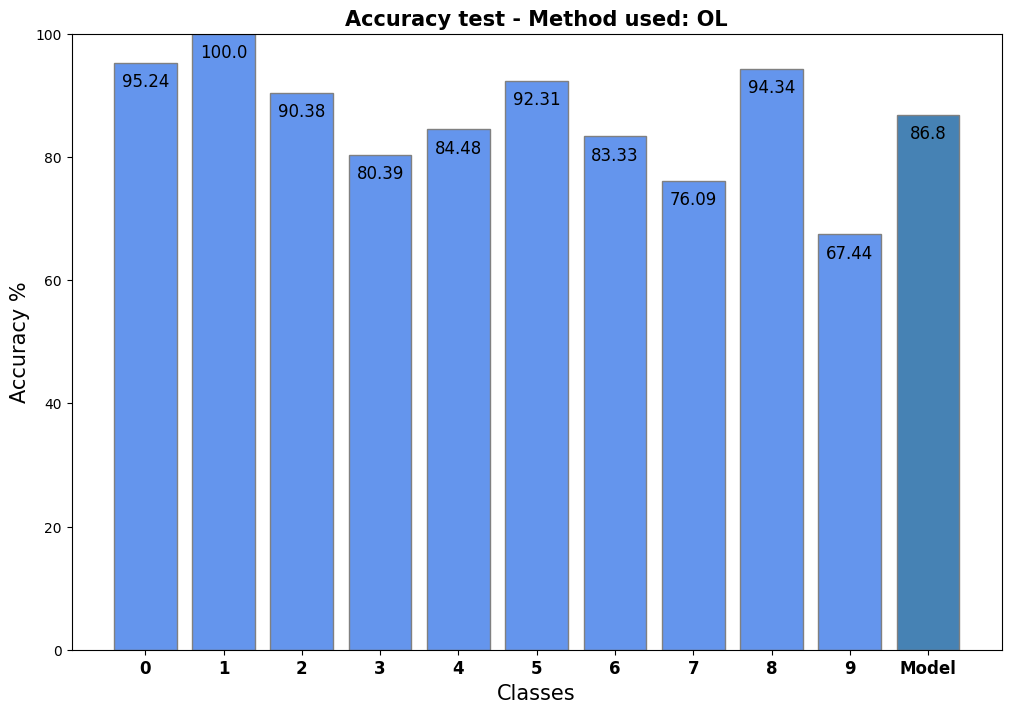

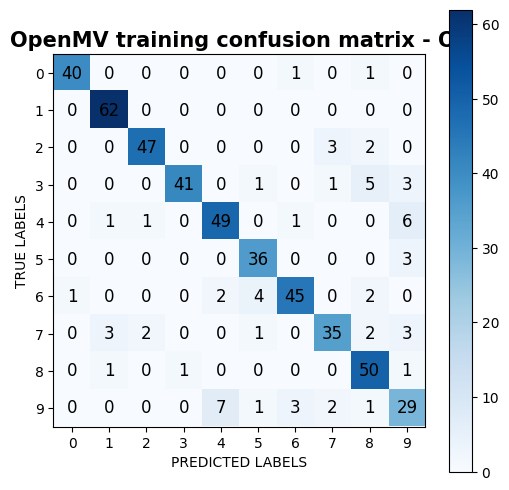

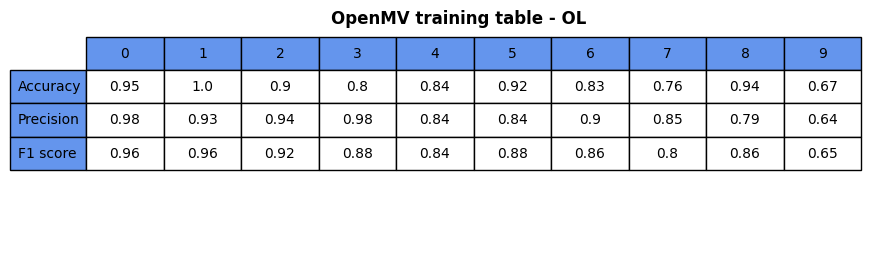

In [26]:
n_feat = 10 # Select number of features
batch_size = 100 # Clustering batch size

MODEL_PATH = 'Models/{}/'.format(n_feat)
features = np.loadtxt(MODEL_PATH + 'll_features.txt')
labels_features = np.loadtxt(MODEL_PATH + 'll_labels_features.txt').astype(int)
model = keras.models.load_model(MODEL_PATH + 'original_mnist_cnn.h5') # Original model 

Model_OL = Custom_Layer(model)
Model_OL.title      = 'OL'
Model_OL.filename   = 'OL'
Model_OL.l_rate     = 0.01
Model_OL.batch_size = 8

trainOneEpoch_OL(Model_OL, digits_train, digits_test,  label_digits_train,  label_digits_test, features, labels_features, batch_size)
#trainOneEpoch_OL(Model_OL, np.concatenate((data_low_train[:25], data_high_train[:25])), np.concatenate((data_low_test[:25], data_high_test[:25])),  np.concatenate((label_low_train[:25], label_high_train[:25])),  np.concatenate((label_low_test[:25], label_high_test[:25])), features, labels_features, batch_size)

#print("The error for this batch are : ")
#print(int(err_tot/tot_samples*100))
#print("%")
#print("\n")

plot_barChart(Model_OL)
plot_confMatrix(Model_OL)
plot_table(Model_OL)